In [ ]:
%pip install avalanche-lib
%pip show avalanche-lib

In [1]:
 import torch
 import torchvision
 from torchvision import datasets, transforms
 import matplotlib.pyplot as plt
 import seaborn as sns
 import numpy as np
 from collections import Counter
 from torchvision.datasets import CIFAR10
 from torch.nn import CrossEntropyLoss
 from torch.optim import Adam
 from avalanche.benchmarks.classic import SplitMNIST, PermutedMNIST, SplitCIFAR10
 from avalanche.models import SimpleMLP, SimpleCNN, LeNet5
 from avalanche.training.supervised import Naive, Cumulative, EWC, Replay
 from avalanche.training.plugins import EvaluationPlugin
 from avalanche.logging import InteractiveLogger, TextLogger
 from avalanche.evaluation.metrics import accuracy_metrics, loss_metrics

2025-05-09 21:26:58.358540: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-09 21:27:00.593591: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-09 21:27:07.783238: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import math
import cv2
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import xml.etree.ElementTree as ET


# Сначала рассмотрим датасет PermutedMNIST и архитектуру AlexNet

In [4]:
# Create a data stream
benchmark = PermutedMNIST(n_experiences=3, seed=123)
train_stream = benchmark.train_stream
test_stream = benchmark.test_stream

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:12<00:00, 817796.72it/s] 


Extracting /home/jupyter/.avalanche/data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /home/jupyter/.avalanche/data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 230867.46it/s]


Extracting /home/jupyter/.avalanche/data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /home/jupyter/.avalanche/data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:00<00:00, 2304224.90it/s]


Extracting /home/jupyter/.avalanche/data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/jupyter/.avalanche/data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 9714701.05it/s]

Extracting /home/jupyter/.avalanche/data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/jupyter/.avalanche/data/mnist/MNIST/raw



In [5]:
for exp_id, experience in enumerate(benchmark.train_stream):
    classes_in_exp = experience.classes_in_this_experience
    print(f"Experience {exp_id} содержит классы: {classes_in_exp}")

Experience 0 содержит классы: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Experience 1 содержит классы: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Experience 2 содержит классы: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [25]:
from avalanche.logging import InteractiveLogger, TextLogger, CSVLogger
from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import accuracy_metrics, loss_metrics, timing_metrics, forgetting_metrics
import matplotlib.pyplot as plt
import pandas as pd
import os

os.makedirs('results', exist_ok=True)

criterion = CrossEntropyLoss()

metrics_loggers = [
    InteractiveLogger(),
    TextLogger(open('results/log_file.txt', 'w')),
    CSVLogger('results/metrics')
]

eval_plugin = EvaluationPlugin(
    accuracy_metrics(epoch=True, experience=True, stream=True),
    loss_metrics(epoch=True, experience=True, stream=True),
    forgetting_metrics(experience=True, stream=True),
    timing_metrics(epoch=True),
    loggers=metrics_loggers,
    collect_all=True
)



In [ ]:
from torchvision.models import alexnet

model = alexnet(weights=None)

# Модификация под PM
model.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)  # Уменьшаем ядро и шаг
model.classifier[-1] = nn.Linear(4096, 10)  # Заменяем выходной слой на 10 классов 

Unknown instance spec: Please select VM configuration

In [27]:
optimizer = Adam(model.parameters(), lr=0.001)


cl_strategy = Cumulative(
    model,
    optimizer,
    criterion,
    #ewc_lambda = 0.4,
    train_mb_size=32,
    train_epochs=5,
    eval_mb_size=32,
    evaluator=eval_plugin,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

/home/jupyter/.local/lib/python3.10/site-packages/avalanche/training/templates/base.py:468: PositionalArgumentsDeprecatedWarning: Avalanche is transitioning to strategy constructors that accept named (keyword) arguments only. This is done to ensure that there is no confusion regarding the meaning of each argument (strategies can have many arguments). Your are passing 3 positional arguments to the Cumulative.__init__ method. Consider passing them as names arguments. The ability to pass positional arguments will be removed in the future.
  warnings.warn(error_str, category=PositionalArgumentsDeprecatedWarning)


In [28]:
for experience in train_stream:
    print(f"Training on experience {experience.current_experience}")
    cl_strategy.train(experience)
    results = cl_strategy.eval(test_stream)


Training on experience 0
-- >> Start of training phase << --
100%|██████████| 1875/1875 [01:05<00:00, 28.68it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.1175
	Time_Epoch/train_phase/train_stream/Task000 = 65.3715
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.5993
100%|██████████| 1875/1875 [01:05<00:00, 28.67it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.4197
	Time_Epoch/train_phase/train_stream/Task000 = 65.4034
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8745
100%|██████████| 1875/1875 [01:05<00:00, 28.52it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.3480
	Time_Epoch/train_phase/train_stream/Task000 = 65.7501
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8955
100%|██████████| 1875/1875 [01:05<00:00, 28.60it/s]
Epoch 3 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.3078
	Time_Epoch/train_phase/train_stream/Task000 = 65.5525
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9089
100

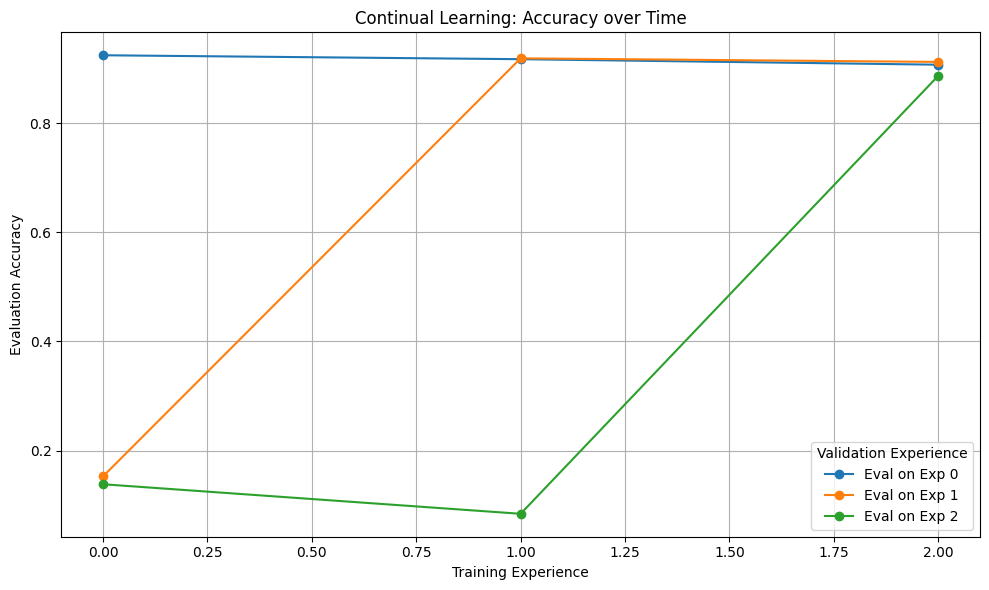

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/home/jupyter/datasphere/project/results/metrics/results/metrics/eval_results.csv")

df = df.sort_values(by=["eval_exp", "training_exp"])

plt.figure(figsize=(10, 6))

for eval_exp in df["eval_exp"].unique():
    subset = df[df["eval_exp"] == eval_exp]
    plt.plot(
        subset["training_exp"],
        subset["eval_accuracy"],
        label=f"Eval on Exp {eval_exp}",
        marker="o"
    )

plt.xlabel("Training Experience")
plt.ylabel("Evaluation Accuracy")
plt.title("Accuracy over Time")
plt.legend(title="Validation Experience")
plt.grid(True)
plt.tight_layout()
plt.show()


# Теперь рассмотрим датасет CRDD

### Класс датасета для CRDD. Для работы с avalanche нужно, чтобы данные  хранились как два тензора samples и targets. 
### Кроме того, метки класса должны быть целыми числами. Поэтому используем LabelEncoder

In [32]:
from sklearn.preprocessing import LabelEncoder
class ClassificationDataSet(Dataset):
    def __init__(self, ds_path):
        self.dataset_path = ds_path
        self.samples = []
        self.targets = []
        self.encoder = LabelEncoder()

        ann_dir = os.path.join(self.dataset_path, "annotations/xmls")
        for xml_file in os.listdir(ann_dir):
            tree = ET.parse(os.path.join(ann_dir, xml_file))
            root = tree.getroot()

            for obj in root.findall('object'):
                label = obj.find('name').text
                bndbox = obj.find('bndbox')

                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)

                img_dir = os.path.join(self.dataset_path, "images")
                file_name = xml_file.replace(".xml", ".jpg")
                img_path = os.path.join(img_dir, file_name)
                image = cv2.imread(img_path)
                tensor = torch.from_numpy(cv2.resize(image[ymin:ymax, xmin:xmax],(224,224))).float()

                self.samples.append(tensor.permute(2,0,1))
                self.targets.append(label)
        self.targets = encoder.fit_transform(self.targets)

    def __getitem__(self, idx):
        return self.samples[idx], self.targets[idx]
    def __len__(self):
        return len(self.targets)


# Датасет несбалансирован, поэтому нужно проводить аугментации

In [33]:
import random
from collections import defaultdict, Counter
from torch.utils.data import Dataset

import random
from collections import defaultdict
from torch.utils.data import Dataset
from torchvision.transforms import Compose



class BalancedDataset(Dataset):
    def __init__(self, original_dataset, transform, target_count_per_class=None):
        #target_count_per_class: Желаемое количество элементов на класс(None - балансировка по максимальному классу)
        self.transform = transform
        self.samples = []
        self.targets = []
        
        self._collect_original_data(original_dataset)
        
        self._balance_dataset(target_count_per_class)

    def _collect_original_data(self, dataset):
        self.original_samples = []
        self.original_targets = []
        
        # проверяем, в каком формате хранятся данные. Итоговый датасет будет в формате, нужном avalanche
        if hasattr(dataset, 'samples') and hasattr(dataset, 'targets'):
            self.original_samples = dataset.samples
            self.original_targets = dataset.targets
        else:
            for data, label in dataset:
                self.original_samples.append(data)
                self.original_targets.append(label)

    def _balance_dataset(self, target_count):
        class_indices = defaultdict(list)
        for idx, label in enumerate(self.original_targets):
            class_indices[label].append(idx)
        
        max_class_size = max(len(indices) for indices in class_indices.values())
        self.target_count = max_class_size if target_count is None else min(target_count, max_class_size)
        
        for label, indices in class_indices.items():
            current_size = len(indices)
            
            for idx in indices:
                self.samples.append(self.original_samples[idx])
                self.targets.append(label)
            
            if current_size < self.target_count:
                needed = self.target_count - current_size
                for _ in range(needed):
                    original_idx = random.choice(indices)
                    original_sample = self.original_samples[original_idx]
                    
                    augmented_sample = self.transform(original_sample)
                    self.samples.append(augmented_sample)
                    self.targets.append(label)

    def __getitem__(self, idx):
        return self.samples[idx], self.targets[idx]

    def __len__(self):
        return len(self.samples)

In [34]:
full_ds = ClassificationDataSet("/home/jupyter/datasphere/project/dataset/RDD2022_China_MotorBike/China_MotorBike/train")

In [35]:
from torchvision import transforms

augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2, 0.2),
])

balanced_dataset = BalancedDataset(
    original_dataset=full_ds,
    transform=augmentation,
    target_count_per_class = 2000
)

In [36]:
from torch.utils.data import Dataset, random_split
train_size = int(0.8 * len(balanced_dataset))
test_size = len(balanced_dataset) - train_size

train_dataset, test_dataset = random_split(
    balanced_dataset, 
    [train_size, test_size],
)

## если просто использовать nc_bechmark с n_experiences=5, получится, что каждый новый опыт - это новый класс, который после никогда не встретится
## Хотим иметь возможность создавать из датасета кастомный benchmark, где бы вручную задавалась структура отдельного experience

In [38]:
from avalanche.benchmarks import dataset_benchmark

def split_dataset_by_ratios(dataset, experience_class_ratios):
    """ experience_class_ratios - список словарей, 
        где i-й словарь соответствует i-му experience.
        ключи словаря - метки классов,
        значения - какую часть от общего числа объектов данного класса хотим добавить в соответствующий experience
        Данные добавляются без повторов, одна и та же пара картинка-метка не может встретиться в нескольких experience
        Сумма долей для i-го класса должна быть <=1 """
    import math
    from collections import defaultdict
    from torch.utils.data import Subset

    # после random_split данные в формате subset. Кусок кода ниже нужен,чтобы добраться внутрь по вложенным subset до dataset.targets
    all_indices = list(range(len(dataset)))
    while isinstance(dataset, Subset):
        all_indices = [dataset.indices[i] for i in all_indices]
        dataset = dataset.dataset

    targets = dataset.targets
    class_to_indices = defaultdict(list)

    for new_idx, real_idx in enumerate(all_indices):
        label = targets[real_idx]
        class_to_indices[label].append(real_idx)

    for cls in class_to_indices:
        class_to_indices[cls] = sorted(class_to_indices[cls])

    used_indices = defaultdict(int)
    experiences = []

    for exp_id, class_ratio_dict in enumerate(experience_class_ratios):
        exp_indices = []

        for cls, ratio in class_ratio_dict.items():
            cls_indices = class_to_indices[cls]
            total_available = len(cls_indices)
            start = used_indices[cls]
            count = math.floor(ratio * total_available)
            end = min(start + count, total_available)

            selected = cls_indices[start:end]
            used_indices[cls] = end
            exp_indices.extend(selected)

        experiences.append(Subset(dataset, exp_indices))

    return experiences


In [39]:
experience_class_ratios = [
    {0: 1.0, 1: 0.5,},  # Exp 0: весь класс 0, половина класса 1
    {1: 0.5, 2: 0.5},  # Exp 1: вторая половина класса 1, первая половина класса 2
    {2: 0.5, 3: 0.5},  # ...
    {3: 0.5, 4: 0.5},
    {4: 0.5}
]

experiences_train = split_dataset_by_ratios(train_dataset, experience_class_ratios)
experiences_test = split_dataset_by_ratios(test_dataset, experience_class_ratios)

benchmark = dataset_benchmark(
    train_datasets=experiences_train,
    test_datasets=experiences_test
)

for i, exp in enumerate(benchmark.train_stream):
    print(f"Experience {i}: классы {exp.classes_in_this_experience}")


Experience 0: классы [0, 1]
Experience 1: классы [1, 2]
Experience 2: классы [2, 3]
Experience 3: классы [3, 4]
Experience 4: классы [4]


In [40]:
train_stream = benchmark.train_stream
test_stream = benchmark.test_stream

# Сначала используем модель SimpleCNN

In [57]:
from avalanche.logging import InteractiveLogger, TextLogger, CSVLogger
from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import accuracy_metrics, loss_metrics, timing_metrics, forgetting_metrics,class_accuracy_metrics
import matplotlib.pyplot as plt
import pandas as pd
import os

os.makedirs('results', exist_ok=True)

model = SimpleCNN()
optimizer = Adam(model.parameters(), lr=0.001)
criterion = CrossEntropyLoss()

metrics_loggers = [
    InteractiveLogger(),
    TextLogger(open('results/log_file.txt', 'w')),
    CSVLogger('results/metrics')
]

eval_plugin = EvaluationPlugin(
    accuracy_metrics(epoch=True, experience=True, stream=True),
    loss_metrics(epoch=True, experience=True, stream=True),
    forgetting_metrics(experience=True, stream=True),
    class_accuracy_metrics(epoch=True, experience=True, stream=True),
    timing_metrics(epoch=True),
    loggers=metrics_loggers,
    collect_all=True
)

cl_strategy = EWC(
    model,
    optimizer,
    criterion,
    ewc_lambda = 0.4,
    #mem_size = 300,
    train_mb_size=32,
    train_epochs=5,
    eval_mb_size=32,
    evaluator=eval_plugin,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

/home/jupyter/.local/lib/python3.10/site-packages/avalanche/training/templates/base.py:468: PositionalArgumentsDeprecatedWarning: Avalanche is transitioning to strategy constructors that accept named (keyword) arguments only. This is done to ensure that there is no confusion regarding the meaning of each argument (strategies can have many arguments). Your are passing 3 positional arguments to the EWC.__init__ method. Consider passing them as names arguments. The ability to pass positional arguments will be removed in the future.
  warnings.warn(error_str, category=PositionalArgumentsDeprecatedWarning)


In [58]:
# Обучение с сохранением метрик
for experience in train_stream:
    print(f"Training on experience {experience.current_experience}")

    # Обучение на текущем опыте
    cl_strategy.train(experience)

    # Тестирование после каждого опыта
    results = cl_strategy.eval(test_stream)


Training on experience 0
-- >> Start of training phase << --
100%|██████████| 92/92 [00:09<00:00,  9.59it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.5926
	Time_Epoch/train_phase/train_stream/Task000 = 9.5958
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.7263
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.8783
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.3153
100%|██████████| 92/92 [00:09<00:00,  9.62it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2666
	Time_Epoch/train_phase/train_stream/Task000 = 9.5631
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8775
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9054
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.8020
100%|██████████| 92/92 [00:09<00:00,  9.60it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.1641
	Time_Epoch/train_phase/train_stream/Task000 = 9.5799
	Top1_Acc_Epoch/train_phase/train_stream/Task000 =

# Теперь используем Lenet5

# Lenet изначально разработана для mnist, поэтому имеет один канал на первом слое. Поэтому для классификации rgb изображений надо внести некоторые изменения. По этой причине avalanche.LeNet5 не подходит

In [62]:
import torch
import torch.nn as nn

class LeNet5_RGB(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            # Изменён первый слой для 3 каналов
            nn.Conv2d(3, 6, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            
            nn.Conv2d(6, 16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(64 * 14 * 14, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [67]:
from avalanche.logging import InteractiveLogger, TextLogger, CSVLogger
from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import accuracy_metrics, loss_metrics, timing_metrics, forgetting_metrics,class_accuracy_metrics
import matplotlib.pyplot as plt
import pandas as pd
import os

os.makedirs('results', exist_ok=True)

model = LeNet5_RGB()
optimizer = Adam(model.parameters(), lr=0.001)
criterion = CrossEntropyLoss()

metrics_loggers = [
    InteractiveLogger(),
    TextLogger(open('results/log_file.txt', 'w')),
    CSVLogger('results/metrics')
]

eval_plugin = EvaluationPlugin(
    accuracy_metrics(epoch=True, experience=True, stream=True),
    loss_metrics(epoch=True, experience=True, stream=True),
    forgetting_metrics(experience=True, stream=True),
    class_accuracy_metrics(epoch=True, experience=True, stream=True),
    timing_metrics(epoch=True),
    loggers=metrics_loggers,
    collect_all=True
)

cl_strategy = EWC(
    model,
    optimizer,
    criterion,
    ewc_lambda = 0.4,
    #mem_size = 300,
    train_mb_size=32,
    train_epochs=5,
    eval_mb_size=32,
    evaluator=eval_plugin,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

/home/jupyter/.local/lib/python3.10/site-packages/avalanche/training/templates/base.py:468: PositionalArgumentsDeprecatedWarning: Avalanche is transitioning to strategy constructors that accept named (keyword) arguments only. This is done to ensure that there is no confusion regarding the meaning of each argument (strategies can have many arguments). Your are passing 3 positional arguments to the EWC.__init__ method. Consider passing them as names arguments. The ability to pass positional arguments will be removed in the future.
  warnings.warn(error_str, category=PositionalArgumentsDeprecatedWarning)


In [68]:
# Обучение с сохранением метрик
for experience in train_stream:
    print(f"Training on experience {experience.current_experience}")

    # Обучение на текущем опыте
    cl_strategy.train(experience)

    # Тестирование после каждого опыта
    results = cl_strategy.eval(test_stream)


Training on experience 0
-- >> Start of training phase << --
100%|██████████| 92/92 [00:02<00:00, 32.41it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.6718
	Time_Epoch/train_phase/train_stream/Task000 = 2.8383
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.7165
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9767
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.0126
100%|██████████| 92/92 [00:02<00:00, 33.63it/s]
Epoch 1 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.5296
	Time_Epoch/train_phase/train_stream/Task000 = 2.7352
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.7434
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/0 = 0.9646
	Top1_ClassAcc_Epoch/train_phase/train_stream/Task000/1 = 0.1450
100%|██████████| 92/92 [00:02<00:00, 33.39it/s]
Epoch 2 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2982
	Time_Epoch/train_phase/train_stream/Task000 = 2.7542
	Top1_Acc_Epoch/train_phase/train_stream/Task000 =

# Все метрики сохраняются в файл eval_results.csv. Графики строим по данным из этих файлов

# Построим график усредненной accuracy после обучений на каждом из experience

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import os
def show_avg_acc_plot(results_dir):
    plt.figure(figsize=(12, 7))

    for filename in os.listdir(results_dir):
        if filename.endswith(".csv"):
            strategy_name = filename.replace(".csv", "").replace("_", " ").title()
            df = pd.read_csv(os.path.join(results_dir, filename))

            mean_acc = df.groupby("training_exp")["eval_accuracy"].mean().reset_index()

            plt.plot(
                mean_acc["training_exp"],
                mean_acc["eval_accuracy"],
                label=strategy_name,
                marker="o",
                linewidth=2
            )

    plt.xlabel("Training Experience", fontsize=12)
    plt.ylabel("Average Evaluation Accuracy", fontsize=12)
    plt.title("Average Accuracy Across All Experiences", fontsize=14)
    plt.legend(title="Learning Strategies", fontsize=10)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()

    plt.show()

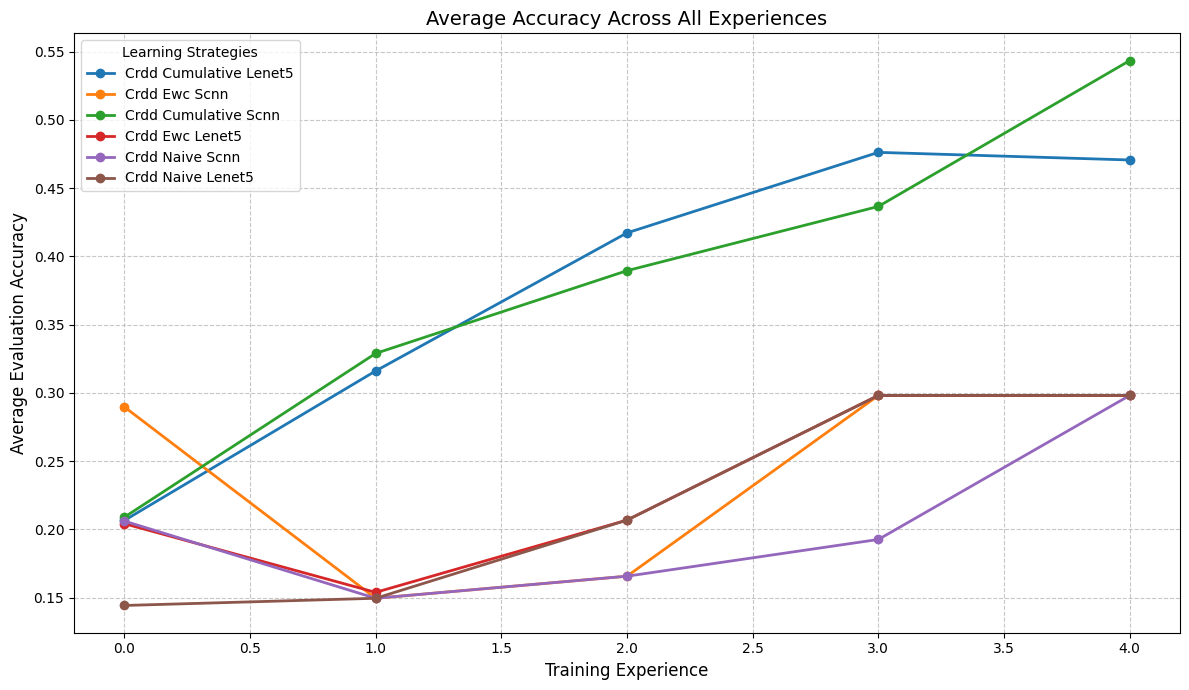

In [8]:
show_avg_acc_plot("/home/jupyter/datasphere/project/res_CL_CRDD")


# Для исследования забывания построим график accuracy на каждом из experience в процессе обучения

In [3]:
def show_exp_to_exp_acc_plot(path):
    import pandas as pd
    import matplotlib.pyplot as plt

    df = pd.read_csv(path)

    df = df.sort_values(by=["eval_exp", "training_exp"])

    plt.figure(figsize=(10, 6))

    for eval_exp in df["eval_exp"].unique():
        subset = df[df["eval_exp"] == eval_exp]
        plt.plot(
            subset["training_exp"],
            subset["eval_accuracy"],
            label=f"Eval on Exp {eval_exp}",
            marker="o"
        )

    plt.xlabel("Training Experience")
    plt.ylabel("Evaluation Accuracy")
    plt.title("Accuracy over Time")
    plt.legend(title="Validation Experience")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


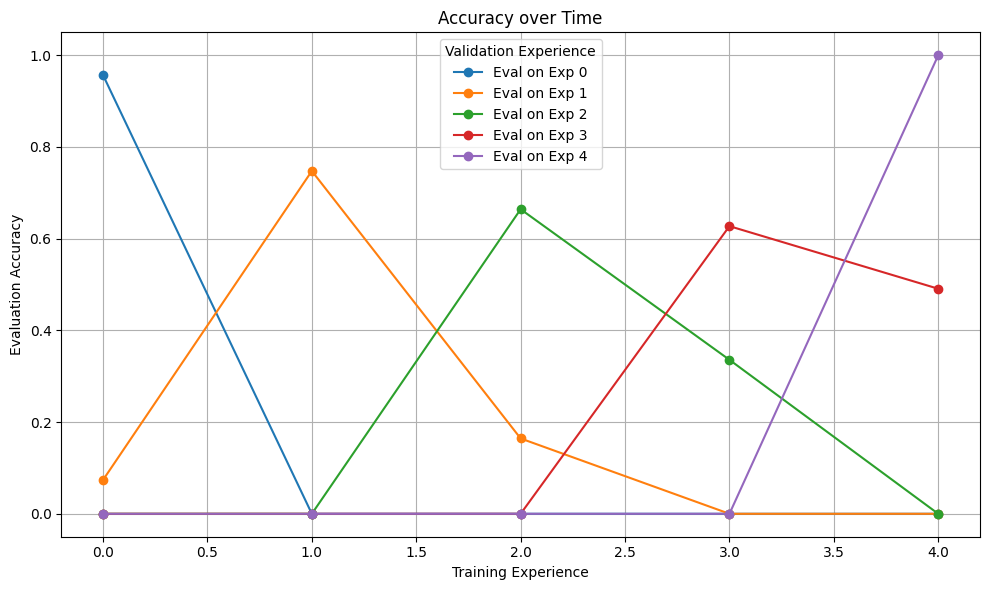

In [4]:
show_exp_to_exp_acc_plot("/home/jupyter/datasphere/project/res_CL_CRDD/CRDD_naive_scnn.csv")

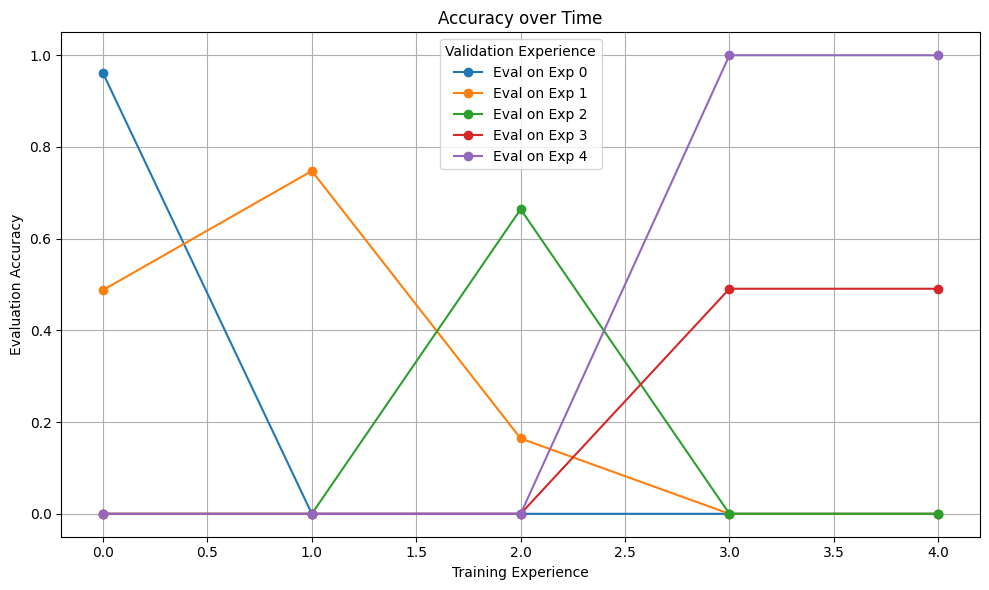

In [5]:
show_exp_to_exp_acc_plot("/home/jupyter/datasphere/project/res_CL_CRDD/CRDD_EWC_scnn.csv")

# Выводы:
PM: для PermutedMnist лучшие результаты показывает cumulative стратегия<br>
CRDD: видим, что при слабой регуляризации(при малых ewc_lambda) поведение EWC похоже на Naive, но EWC все равно несколько лучше справляется<br>
SCNN и LeNet это достаточно малельние модели, не очень хорошо подходящие для классификации дорожных дефектов<br>
Лучшие результты также показывает Cumulative<br>